# Menghasilkan kumpulan data berlabel menggunakan OWLv2

Di buku catatan ini, kami akan mendemonstrasikan cara membuat kumpulan data gambar berlabel menggunakan OWLv2. Seperti pendahulunya OWL-ViT, OWLv2 adalah model deteksi objek berkondisi teks zero-shot. OWL-ViT diperkenalkan di [Deteksi Objek Kosakata Terbuka Sederhana dengan Vision Transformers](https://arxiv.org/abs/2205.06230) oleh Minderer, et. al., dan OWLv2 diperkenalkan di [Scaling Open-Vocabulary Object Detection](https://arxiv.org/pdf/2306.09683.pdf) oleh Minderer, et. al. Anda dapat mempelajari lebih lanjut tentang model OWLv2 [di sini](https://huggingface.co/docs/transformers/model_doc/owlv2).

Buku catatan ini diadaptasi dari [di sini](https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb).

Jalankan sel ini jika Anda telah membuat kumpulan data yang besar. Contoh mainan ini tidak diperlukan.

In [1]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Pertama, mari kita instal dependensinya.

In [2]:
!pip install -q transformers huggingface_hub datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Mari masuk ke Hugging Face Hub dengan token akses WRITE kita.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

We need CUDA to run this notebook.

In [4]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Mari kita tulis fungsi untuk menggunakan Owlv2 guna mendeteksi objek dalam gambar dan mengembalikan gambar beranotasi dengan kotak pembatas dan daftar nama objek.  Pertama, kita akan membuat fungsi utilitas untuk menghitung berapa kali suatu objek muncul pada gambar.

In [5]:
def count_labels(input_array):
    label_count = {}
    for item in input_array:
        if item in label_count:
            label_count[item] += 1
        else:
            label_count[item] = 1
    return label_count

In [6]:
import matplotlib.pyplot as plt

# Process the image and retrieve the significant texts
def get_predictions(image, text_queries, model, processor, score_threshold, path):
    # Process the image, and text queries
    inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

    # Set model in evaluation mode
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
      outputs = model(**inputs)

    # Get prediction logits
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

    significant_labels = []
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    # Threshold to eliminate low probability predictions
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      else:
        cx, cy, w, h = box
        ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
        ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.1"
          })
        fig.savefig(path)
        plt.close()

        # Grab significant labels and count
        significant_labels.append(text_queries[label])
        counted_labels = count_labels(significant_labels)
    return counted_labels

Mari tambahkan fungsi pembantu untuk menghasilkan label untuk gambar. Jika model tidak mendeteksi objek apa pun, labelnya menjadi "Tidak Ada".  Jika tidak, label akan menunjukkan berapa kali suatu objek muncul dalam gambar.

In [7]:
def add_labels(label_dict):
    labels = list(label_dict.keys())
    if not labels:
        return "None"
    else:
        formatted_labels = []
        for label in labels:
            count = label_dict[label]
            formatted_label = f'{count} {label}'
            # We will return the plural if the object appears more than once in the image
            if count > 1:
                formatted_label += 's'
            formatted_labels.append(formatted_label)
        # if you want the labels without the count substitute labels for formatted_labels
        return ', '.join(formatted_labels)

Kami siap memproses gambar!  Kami akan meneruskan gambar kami dan daftar kueri teks ke model dan akan mendapatkan kembali daftar objek yang terdeteksi. Penting untuk dicatat bahwa kita juga perlu menetapkan ambang skor untuk seberapa yakin model tersebut bahwa suatu objek telah terdeteksi.

*Kiat Profesional:*

  Anda mungkin perlu bereksperimen dengan nilai ambang skor yang berbeda untuk mencegah kesalahan positif.

In [8]:
import os
import requests
from PIL import Image
from io import BytesIO
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# We will grab some images from the hf-vison course-assets
url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/label_dataset_owlv2"

# Alternately, you can load images from a local folder
# path = ""

# Set the text queries
text_queries = ["dog", "table", "chair", "book", "magazine", "bookcase", "fireplace", "plant", "tree", "mountain", "lake", "light", "window", "basketball", "soccer ball", "football", "volleyball", "hola hoop", "car"]

# Set the number of images to generate
num_images = 10

# Set the score threshold (a lower value makes it more likely that an object is detected)
score_threshold = 0.20

# Create a directory for the annotated images
annotated_images_dir = "/content/annotated_images"
os.makedirs(annotated_images_dir, exist_ok=True)

# Write a function to add images to the dataset
def add_images(idx, text_queries):
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

    # Get the URL for an image
    image_url = f'{url}/{idx}.jpeg'

    # Download the image
    response = requests.get(image_url)
    image_content = response.content

    # Open the image using PIL
    image = Image.open(BytesIO(image_content))

    # Alternately, you can load images from a local folder
    # image = Image.open(f'{path}/{idx}.jpeg').

    # Get predictions
    annotated_path = f'{annotated_images_dir}/{idx}.jpeg'
    # Get predictions
    labels = get_predictions(image, text_queries, model, processor, score_threshold, annotated_path)
    label = add_labels(labels)
    annotated_image = Image.open(annotated_path)

    # Add image and label to the dataset
    return {
        "image": image,
        "annotated_image": annotated_image,
        "label": label,
    }

def generate_entries():
    for i in range(num_images):
        yield add_images(i, text_queries)

Kami sekarang siap untuk memasukkan kumpulan data kami ke hub Hugging Face. Kami memiliki beberapa opsi tentang cara melakukan ini.

* Gunakan folder gambar dengan file metajsonl
* Gunakan generator

Kami akan melakukan demo menggunakan metode generator, yang merupakan cara hemat memori untuk membuat kumpulan data karena melakukan iterasi melalui gambar. Anda dapat membaca selengkapnya tentang menambahkan kumpulan data [di sini](https://huggingface.co/docs/datasets/en/create_dataset).

In [12]:
from datasets import Dataset

username = "Hazelnut27"
repo_id = "labeled_images_demo"

# Create a dataset from the generator
ds = Dataset.from_generator(generate_entries)
ds.push_to_hub(f'{username}/{repo_id}')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/353 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/Hazelnut27/labeled_images_demo/commit/c2d96975d625626427aa65ac71aee6f12e80c904', commit_message='Upload dataset', commit_description='', oid='c2d96975d625626427aa65ac71aee6f12e80c904', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Hazelnut27/labeled_images_demo', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Hazelnut27/labeled_images_demo'), pr_revision=None, pr_num=None)

In [13]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('Hazelnut27/labeled_images_demo')


train-00000-of-00001.parquet:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's take a look at one of the image, label pairs in our new dataset. The image shows a table and chairs with some lights and a plant.

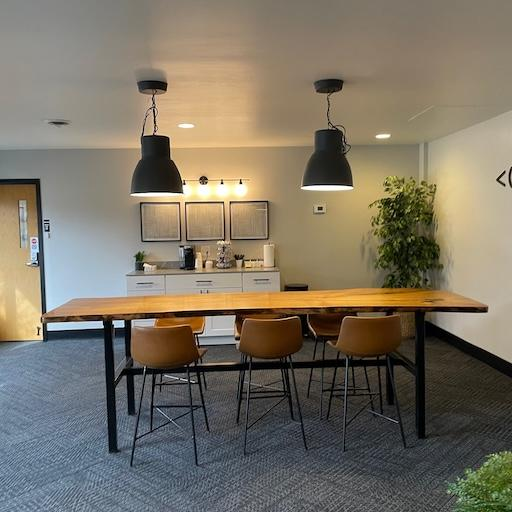

In [14]:
dataset["train"][0]["image"]

If we look at the label, we can see that the model has correctly identified the objects in the photo. However, it appears to have over-counted the number of plants.

In [15]:
dataset["train"][0]["label"]

'10 lights, 4 plants, 1 table, 6 chairs'

Let's also take a look at the annotated image. We can see that the canisters on the counter was labeled as plants.

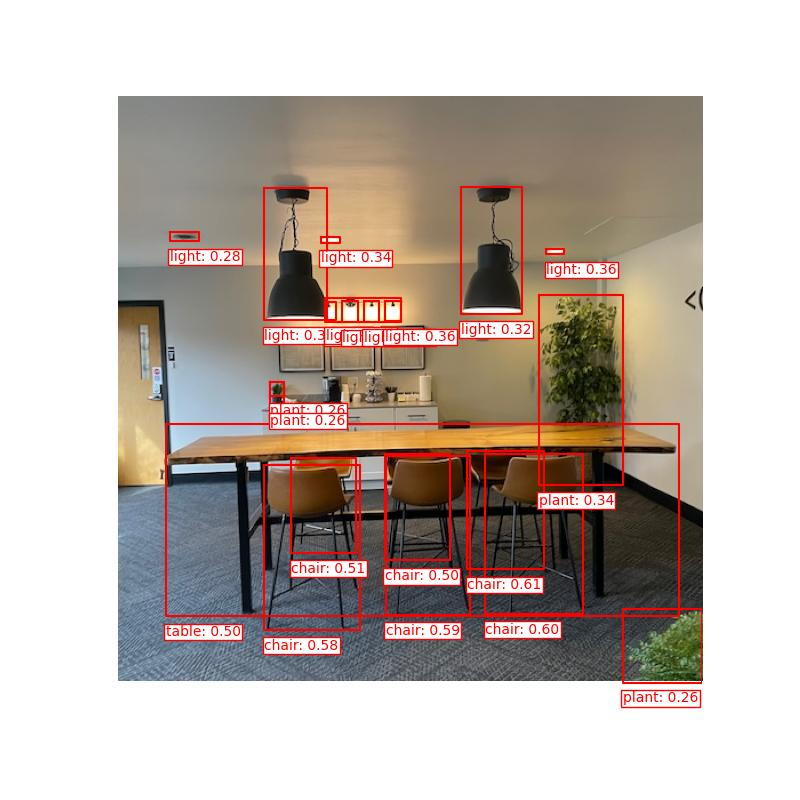

In [16]:
dataset["train"][0]["annotated_image"]

Now, let's take a look at a different image, pair.

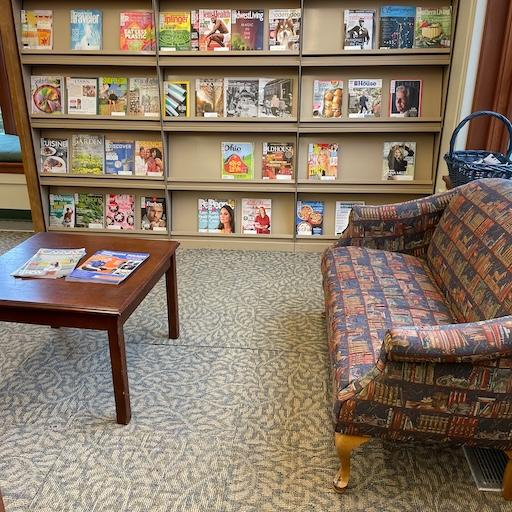

In [17]:
dataset["train"][7]["image"]

Now let's look at the label.

In [18]:
dataset["train"][7]["label"]

'5 books, 51 magazines, 1 dog, 4 bookcases, 1 table'

Hmmm...notice something a bit odd? The model has detected a dog in the image! This seems wrong. However, if you look closely at the annotated image, you can see that one of the magazines has a dog on the cover. Another issue is that the model can mislabel and/or over-count objects.  For example, a couple of the magazines have been mislabeled as books. It has also miscounted the number of bookcases in the image.


Both of these examples highlight the importance of experimenting with different threshold levels and double-checking the predicted labels to make sure you are getting the results that you expect!!

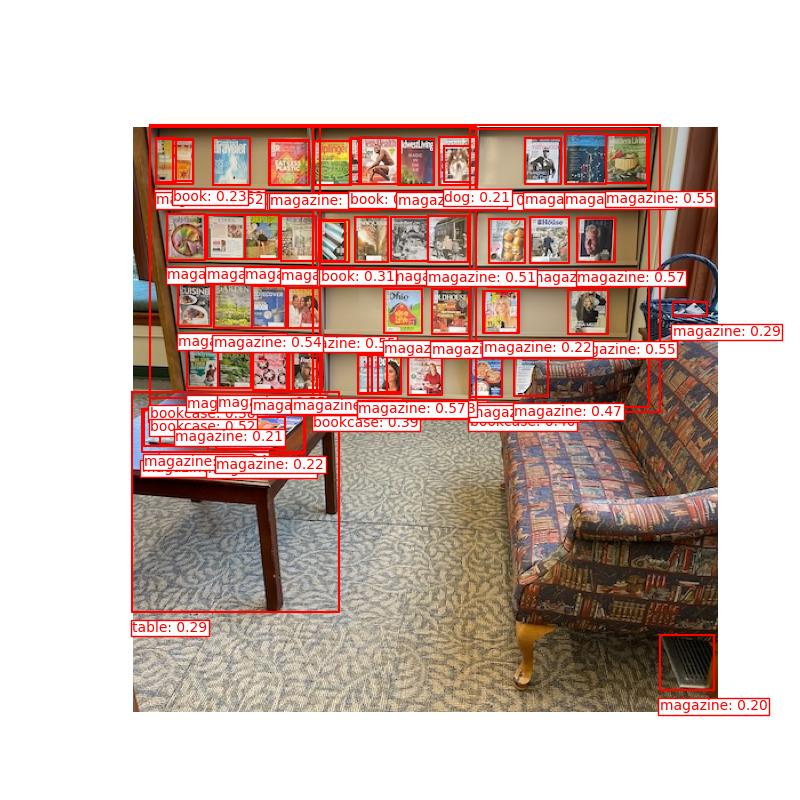

In [19]:
dataset["train"][7]["annotated_image"]